In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/model2/pytorch/default/1").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/input/model2/pytorch/default/1")
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl
# from data.datasets import set_seed

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "/kaggle/input/crohme-by-me/data_inverted", 
                 csv_file = "caption.csv",
                 transform = None, use_float16 = False,
                 device = device,
                 partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        self.labels = pd.read_csv(self.csv_path, usecols=['label', 'col'])
        
        # Remove '.png' from filenames in the 'col' column
        #self.labels['col'] = self.labels['col'].str.replace('.png', '', regex=False)
        
        # Split data into training and validation sets
#         self.labels, self.labels_val = train_test_split(self.labels, test_size=test_split, random_state=random_seed)

        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        if self.partition == "train":
            img_name = os.path.join(self.img_dir, self.labels.iloc[idx]["col"])  # Use "col" for filenames
        else:
            img_name = os.path.join(self.img_dir, self.labels_val.iloc[idx]["col"])  # Use "col" for filenames

        image = Image.open(img_name+'.bmp').convert('RGB')
        inputs = self.processor(images=image, padding="max_length", return_tensors="pt").to(self.device)
        
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze()  # Remove batch dimension

        if self.partition == "train":
            caption = self.labels.iloc[idx]["label"]  # Use "label" for captions
        else:
            caption = self.labels_val.iloc[idx]["label"]  # Use "label" for captions
        
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding="max_length", max_length=256,
        ).to(self.device).squeeze()

        return inputs, caption

        
def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 2 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = MathCaptionsDataset(processor); train_ds.train()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_ds = MathCaptionsDataset(processor); val_ds.val()
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
assert (train_ds.labels_val.values == val_ds.labels_val.values).all()

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [2]:
# Install jiwer for CER calculation
!pip install jiwer

# Import jiwer for CER calculation
from jiwer import cer

# ... your code remains unchanged until the training loop ...

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.7 MB/s eta 0:00:0000:0100:01


In [3]:
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.99
scaler = t.cuda.amp.GradScaler(enabled=True)

# Training and validation loop with CER calculation
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]

            optimizer.zero_grad()
            with t.autocast(device_type="cuda", dtype=t.float16, enabled=True):
                outputs = model(pixel_values=pixel_values, labels=captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    # Validation phase
    model.eval()
    with t.no_grad():
        val_losses = []
        cer_scores = []  # To store CER for each validation sample

        for batch, captions in tqdm(val_dl, desc="Validation"):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values=pixel_values, labels=captions)
            val_losses.append(outputs.loss.item())

            # Generate predictions and calculate CER
            generated_tokens = model.generate(pixel_values, max_new_tokens=256)
            predictions = processor.batch_decode(generated_tokens, skip_special_tokens=True)

            # Calculate CER for each prediction vs ground truth
            for pred, true_caption in zip(predictions, captions):
                true_caption = processor.decode(true_caption, skip_special_tokens=True)
                cer_score = cer(true_caption, pred)
                cer_scores.append(cer_score)
        
        avg_val_loss = np.mean(val_losses)
        avg_cer = np.mean(cer_scores)
        print(f"Validation Loss: {avg_val_loss}, CER: {avg_cer}")

        val_history.append(avg_val_loss)
        val_timesteps.append(len(history) - 1)
        model.train()  # Switch back to training mode after validation

# Save model and processor
model.save_pretrained("/kaggle/working/model2/model/trocr_model_im2latex")
processor.save_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

# Load model for testing
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/model2/model/trocr_model_im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

# Display a random validation result with CER
import random
model.eval()

idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name+'.bmp').convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math

display(image)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens=256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))

# Calculate CER for this specific sample
cer_value = cer(caption, pred)
print(f"CER for this sample: {cer_value:.4f}")

print("Ground Truth:")
print(caption)
display(Math(caption))

/tmp/ipykernel_30/2432849727.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = t.cuda.amp.GradScaler(enabled=True)
Epoch 1/5:   0%|          | 0/4867 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Validation: 100%|██████████| 1217/1217 [30:13<00:00,  1.49s/it] 


Validation Loss: 0.0216508570461381, CER: 0.16536182581415473


Validation: 100%|██████████| 1217/1217 [32:54<00:00,  1.62s/it] 


Validation Loss: 0.023061768197014942, CER: 0.20788484437781055


Validation: 100%|██████████| 1217/1217 [39:50<00:00,  1.96s/it] 


Validation Loss: 0.02088077085693824, CER: 0.2568937388347293


Epoch 4/5:  17%|█▋        | 834/4867 [08:26<40:47,  1.65it/s, loss=0.0151] 


KeyboardInterrupt: 

In [6]:
import random 

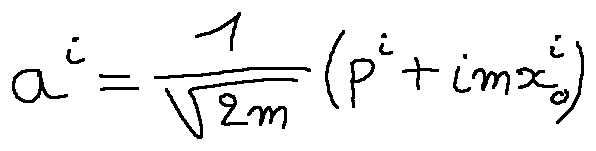

Prediction:
a ^ { i } = \frac { 1 } { \sqrt { 2 m } } ( P ^ { i } + i x _ { 0 } ^ { i } )


<IPython.core.display.Math object>

CER for this sample: 0.0380
Ground Truth:
a ^ { i } = \frac { 1 } { \sqrt { 2 m } } ( p ^ { i } + i m x _ { 0 } ^ { i } )


<IPython.core.display.Math object>

In [7]:
idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name+'.bmp').convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math

display(image)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens=256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))

# Calculate CER for this specific sample
cer_value = cer(caption, pred)
print(f"CER for this sample: {cer_value:.4f}")

print("Ground Truth:")
print(caption)
display(Math(caption))

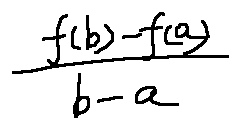

Prediction:
\frac { f ( b ) - f ( a ) } { b - a }


<IPython.core.display.Math object>

CER for this sample: 0.0000
Ground Truth:
\frac { f ( b ) - f ( a ) } { b - a }


<IPython.core.display.Math object>

In [8]:
# Save model and processor
model.save_pretrained("/kaggle/working/model2/model/trocr_model_im2latex")
processor.save_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

# Load model for testing
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/model2/model/trocr_model_im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

# Display a random validation result with CER
import random
model.eval()

idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name+'.bmp').convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math

display(image)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens=256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))

# Calculate CER for this specific sample
cer_value = cer(caption, pred)
print(f"CER for this sample: {cer_value:.4f}")

print("Ground Truth:")
print(caption)
display(Math(caption))

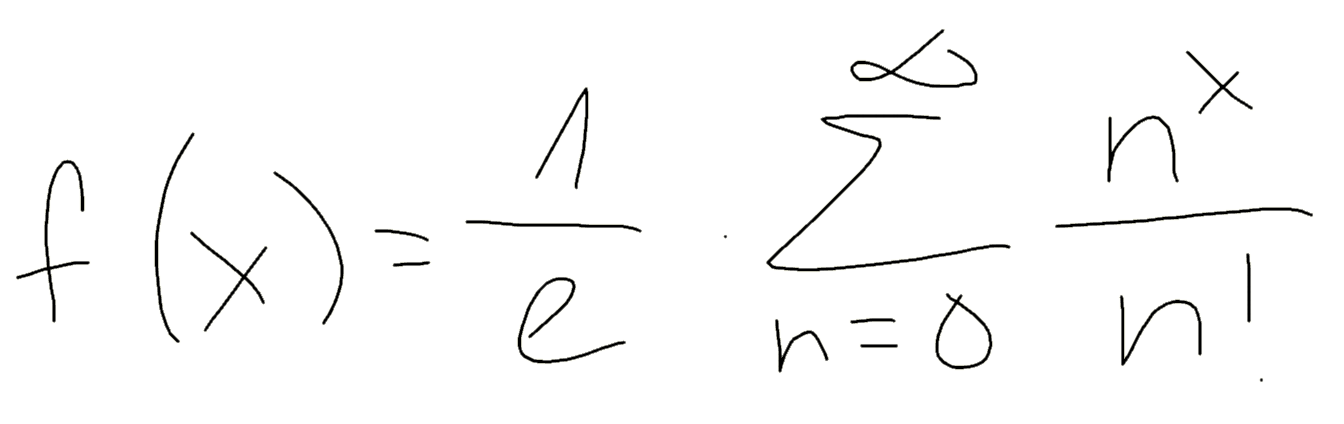

Prediction:
f ( x ) = \frac { 1 } { a } \sum _ { n = 0 } ^ { \infty } \frac { n ^ { x } } { n ! }


<IPython.core.display.Math object>

In [18]:
# Save model and processor


# Function to test your own image
def test_custom_image(image_path):
    model.eval()
    # Load your image
    image = Image.open(image_path).convert('RGB')
    display(image)  # Display the image

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    out = model.generate(pixel_values, max_new_tokens=256)
    print("Prediction:")
    pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
    print(pred)
    display(Math(pred))

# Specify the path to your image
custom_image_path = "/kaggle/input/xs-vffbxv/ink-00fa30d283e278e8.png"  # Replace with your image file path
test_custom_image(custom_image_path)


In [19]:
import shutil

# Zip the saved model directory
shutil.make_archive("/kaggle/working/model2/model/", 'zip', "/kaggle/working/model2/model/")

'/kaggle/working/model2/model/.zip'

In [27]:
 %cd /kaggle/working
from IPython.display import FileLink

FileLink(r'/model2/model/.zip')

/kaggle/working


/model2/model/.zip

In [1]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset, DataLoader
from jiwer import cer
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and processor
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/model2/pytorch/default/1").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/input/model2/pytorch/default/1")

# Dataset class
class MathCaptionsDataset(Dataset):
    def __init__(self, processor, img_dir, csv_file, split="train", transform=None, device=device):
        self.img_dir = img_dir
        self.labels = pd.read_csv(os.path.join(img_dir, csv_file))
        self.processor = processor
        self.transform = transform
        self.device = device
        
        # Split dataset
        train_val, self.test_data = train_test_split(self.labels, test_size=0.10, random_state=42)
        self.train_data, self.val_data = train_test_split(train_val, test_size=0.15 / 0.85, random_state=42)
        
        if split == "train":
            self.data = self.train_data
        elif split == "val":
            self.data = self.val_data
        else:
            self.data = self.test_data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.data.iloc[idx]["col"])
        image = Image.open(img_name + '.bmp').convert('RGB')

        # Apply processor to the image
        inputs = self.processor(images=image, padding="max_length", return_tensors="pt").to(self.device)
        for key in inputs:
            inputs[key] = inputs[key].squeeze()

        caption = self.data.iloc[idx]["label"]
        caption_tokens = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding="max_length", max_length=256
        ).to(self.device).squeeze()

        return inputs, caption_tokens

# Set seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
# Hyperparameters
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 3
SHUFFLE_DATASET = True

In [4]:
# Dataset paths
IMG_DIR = "/kaggle/input/crohme-by-me/data_inverted"
CSV_FILE = "caption.csv"

# DataLoaders
train_dataset = MathCaptionsDataset(processor, IMG_DIR, CSV_FILE, split="train")
val_dataset = MathCaptionsDataset(processor, IMG_DIR, CSV_FILE, split="val")
test_dataset = MathCaptionsDataset(processor, IMG_DIR, CSV_FILE, split="test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Model configuration
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Training loop
scaler = torch.cuda.amp.GradScaler(enabled=True)
model.train()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    for batch, captions in tqdm(train_loader, desc="Training"):
        pixel_values = batch["pixel_values"]
        optimizer.zero_grad()

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=True):
            outputs = model(pixel_values=pixel_values, labels=captions)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # Validation phase
    model.eval()
    val_losses = []
    cer_scores = []

    with torch.no_grad():
        for batch, captions in tqdm(val_loader, desc="Validation"):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values=pixel_values, labels=captions)
            val_losses.append(outputs.loss.item())

            # Generate predictions and calculate CER
            generated_tokens = model.generate(pixel_values, max_new_tokens=256)
            predictions = processor.batch_decode(generated_tokens, skip_special_tokens=True)

            for pred, true_caption in zip(predictions, captions):
                true_caption = processor.decode(true_caption, skip_special_tokens=True)
                cer_score = cer(true_caption, pred)
                cer_scores.append(cer_score)

        avg_val_loss = np.mean(val_losses)
        avg_cer = np.mean(cer_scores)
        print(f"Validation Loss: {avg_val_loss:.4f}, CER: {avg_cer:.4f}")

    model.train()

/tmp/ipykernel_30/799579652.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


Epoch 1/5


Training:   0%|          | 0/3006 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Validation: 100%|██████████| 645/645 [27:45<00:00,  2.58s/it]  


Validation Loss: 0.0196, CER: 0.2000
Epoch 2/5


Validation: 100%|██████████| 645/645 [29:40<00:00,  2.76s/it] 


Validation Loss: 0.0167, CER: 0.2051
Epoch 3/5


Validation: 100%|██████████| 645/645 [28:00<00:00,  2.61s/it]  


Validation Loss: 0.0175, CER: 0.1692
Epoch 4/5


Validation: 100%|██████████| 645/645 [28:21<00:00,  2.64s/it] 


Validation Loss: 0.0136, CER: 0.1318
Epoch 5/5


Validation: 100%|██████████| 645/645 [26:51<00:00,  2.50s/it]

Validation Loss: 0.0124, CER: 0.0912


In [6]:
# Save model and processor
model.save_pretrained("/kaggle/working/model2/model/trocr_model_im2latex")
processor.save_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

[]

In [7]:
# Test phase
model.eval()
test_cer_scores = []

with torch.no_grad():
    for batch, captions in tqdm(test_loader, desc="Testing"):
        pixel_values = batch["pixel_values"]
        generated_tokens = model.generate(pixel_values, max_new_tokens=256)
        predictions = processor.batch_decode(generated_tokens, skip_special_tokens=True)

        for pred, true_caption in zip(predictions, captions):
            true_caption = processor.decode(true_caption, skip_special_tokens=True)
            cer_score = cer(true_caption, pred)
            test_cer_scores.append(cer_score)

avg_test_cer = np.mean(test_cer_scores)
print(f"Test CER: {avg_test_cer:.4f}")

Testing:   0%|          | 0/406 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Testing: 100%|██████████| 406/406 [12:58<00:00,  1.92s/it]

Test CER: 0.0874


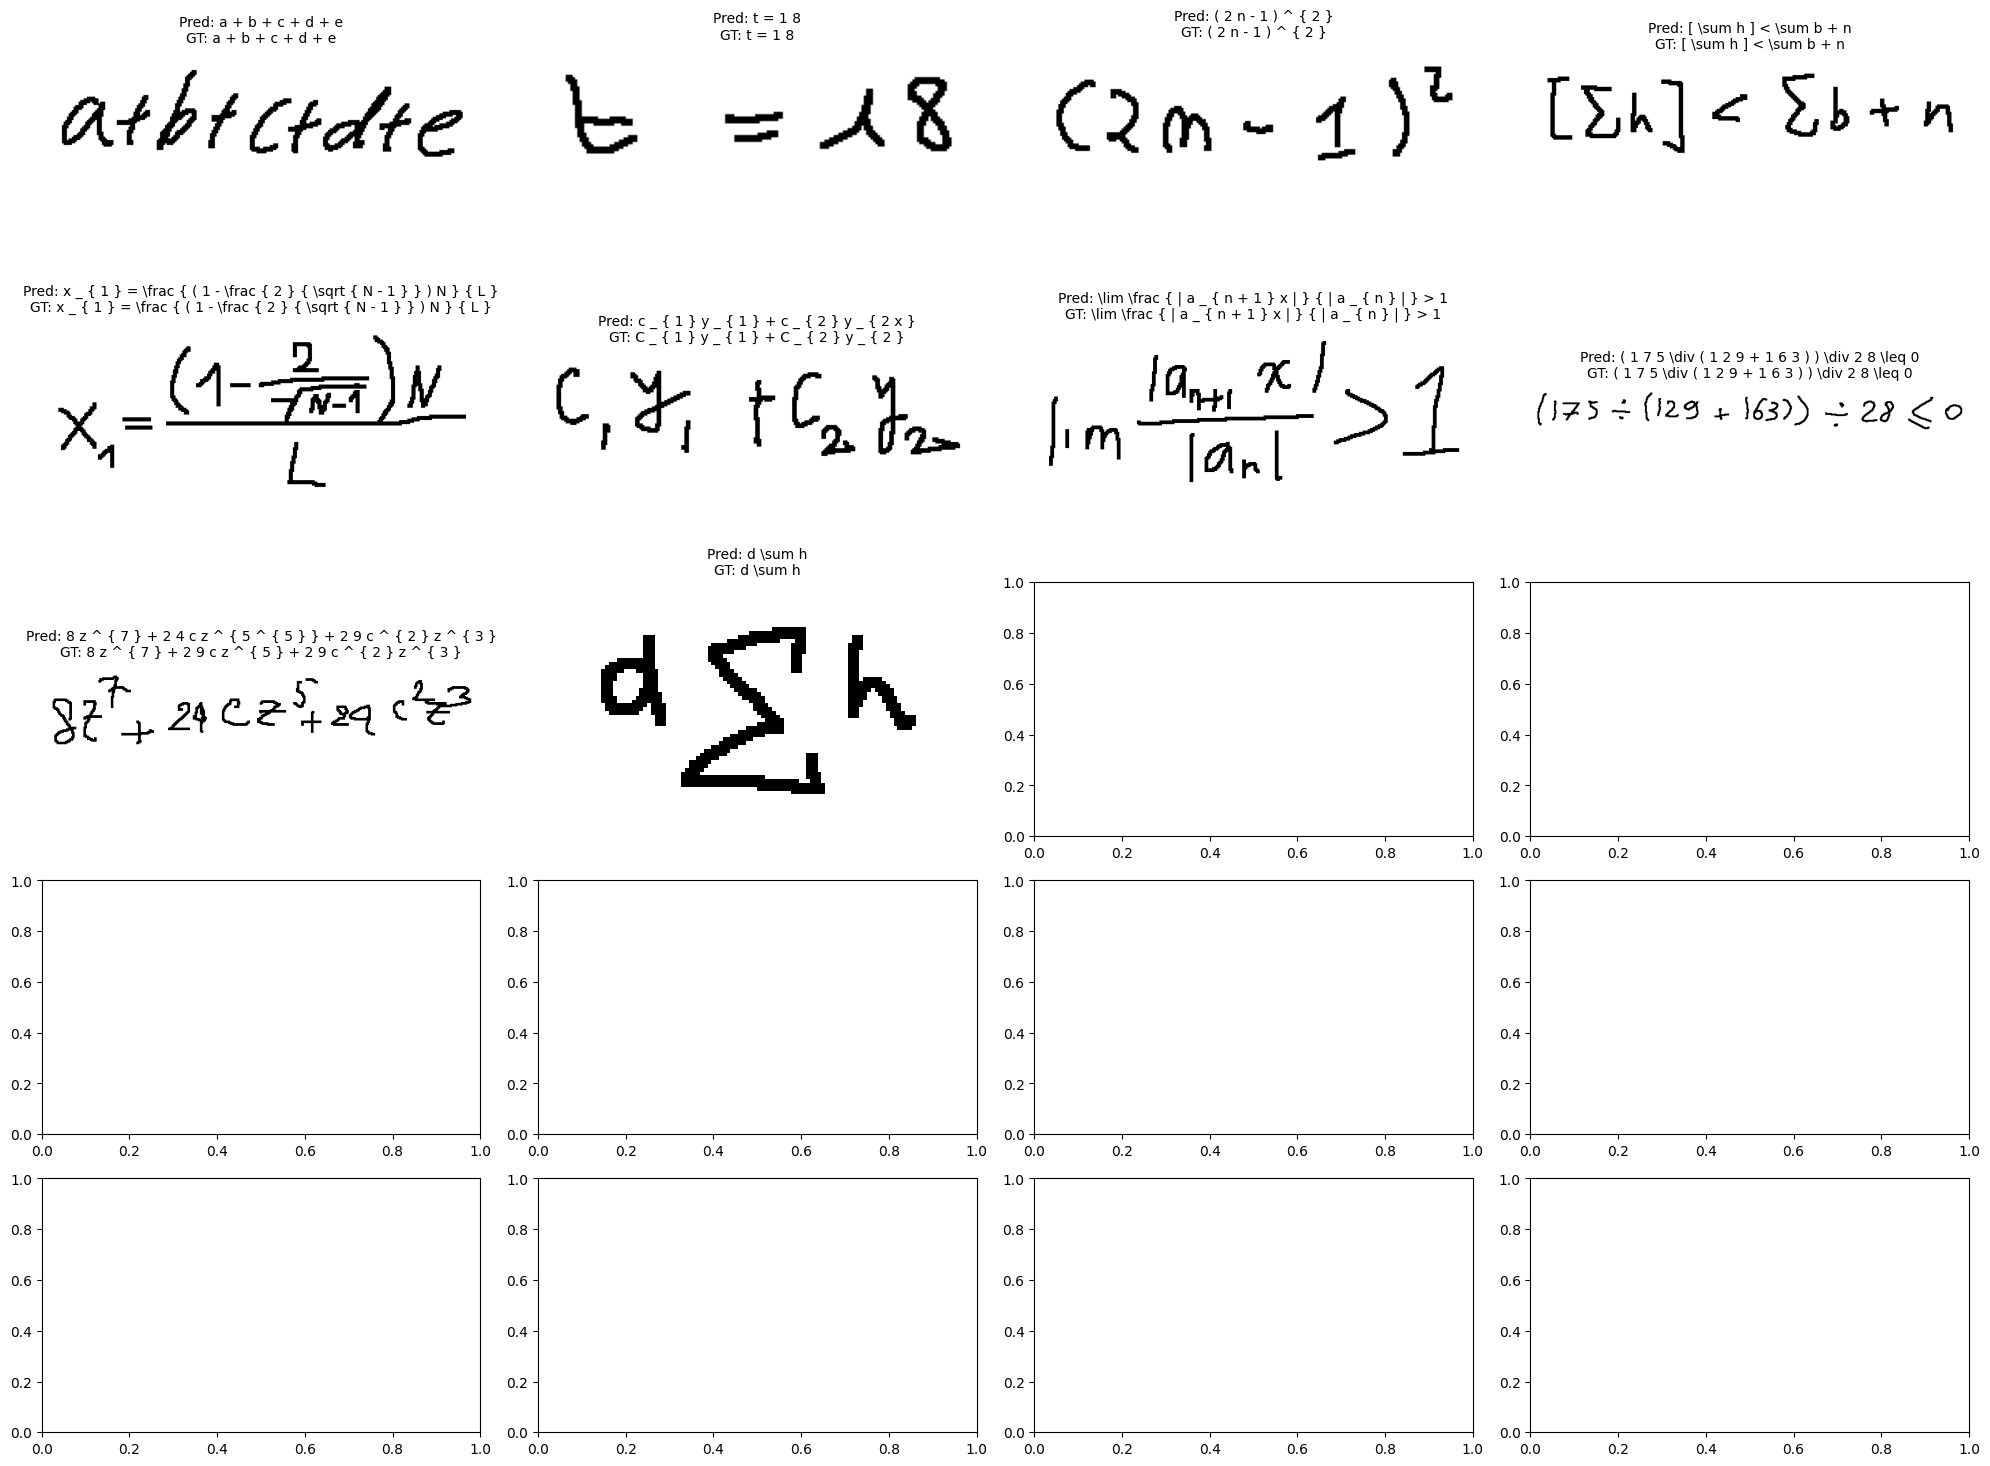

In [9]:
import matplotlib.pyplot as plt

# Function to visualize predictions and ground truth
def visualize_predictions(test_dataset, model, processor, num_samples=20):
    model.eval()  # Set the model to evaluation mode
    
    fig, axes = plt.subplots(5, 4, figsize=(20, 15))  # Create a grid for 20 images
    axes = axes.flatten()
    
    count = 0
    with torch.no_grad():
        for idx in range(len(test_dataset)):
            if count >= num_samples:
                break
            
            # Get the sample
            inputs, ground_truth = test_dataset[idx]
            pixel_values = inputs["pixel_values"].unsqueeze(0).to(device)
            
            # Generate predictions
            generated_tokens = model.generate(pixel_values, max_new_tokens=256)
            prediction = processor.decode(generated_tokens[0], skip_special_tokens=True)
            
            # Decode ground truth
            ground_truth_text = processor.decode(ground_truth, skip_special_tokens=True)
            
            # Load the corresponding image
            img_path = os.path.join(test_dataset.img_dir, test_dataset.data.iloc[idx]["col"] + '.bmp')
            image = Image.open(img_path).convert('RGB')
            
            # Display the image, prediction, and ground truth
            axes[count].imshow(image)
            axes[count].set_title(f"Pred: {prediction}\nGT: {ground_truth_text}", fontsize=10)
            axes[count].axis("off")
            
            count += 1

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(test_dataset, model, processor, num_samples=10)


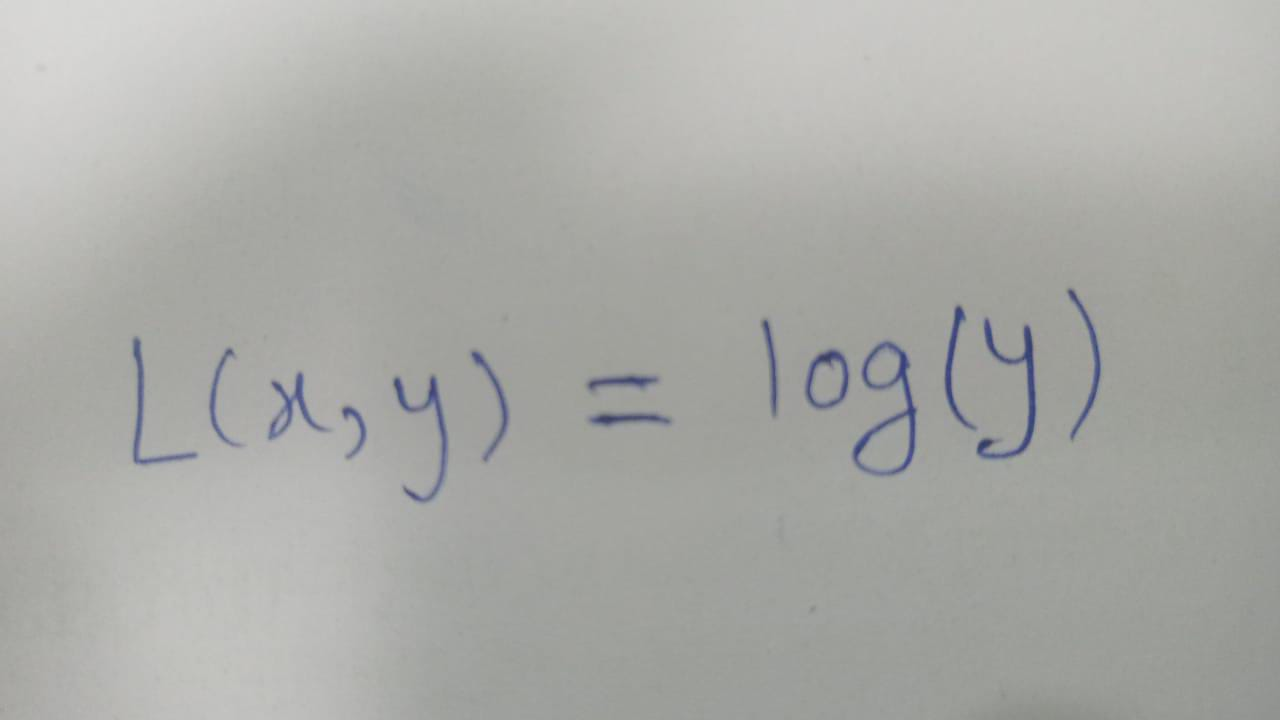

Prediction:
L ( x , y ) = \log ( y )


<IPython.core.display.Math object>

In [12]:
# Save model and processor
from IPython.display import display, Math


# Function to test your own image
def test_custom_image(image_path):
    model.eval()
    # Load your image
    image = Image.open(image_path).convert('RGB')
    display(image)  # Display the image

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    out = model.generate(pixel_values, max_new_tokens=256)
    print("Prediction:")
    pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
    print(pred)
    display(Math(pred))

# Specify the path to your image
custom_image_path = "/kaggle/input/qwertyuiopasdfghjkl/WhatsApp Image 2024-11-07 at 19.26.15_752fb0e6.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)


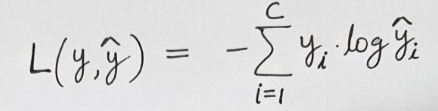

Prediction:
L ( y , y ) = - \sum _ { i = 1 } ^ { c } y _ { i } \cdot \log y _ { i } }


<IPython.core.display.Math object>

In [14]:
# Save model and processor
from IPython.display import display, Math


# Function to test your own image
def test_custom_image(image_path):
    model.eval()
    # Load your image
    image = Image.open(image_path).convert('RGB')
    display(image)  # Display the image

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    out = model.generate(pixel_values, max_new_tokens=256)
    print("Prediction:")
    pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
    print(pred)
    display(Math(pred))

# Specify the path to your image
custom_image_path = "/kaggle/input/asdfghjkl/WhatsApp Image 2024-11-18 at 20.37.30_e852c049.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)


In [16]:
from IPython.display import display, Math

display(Math(r"L(y, y) = - \sum_{i=1}^{c} y_i \cdot \log y_i"))


<IPython.core.display.Math object>

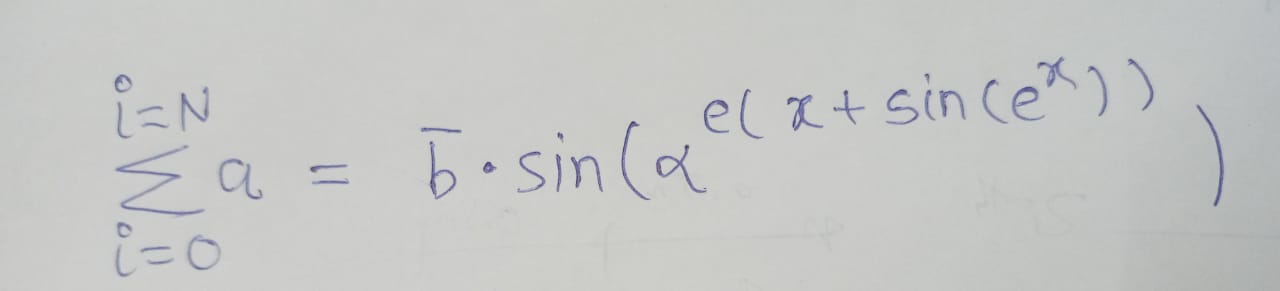

Prediction:
\sum _ { i = 0 } ^ { N } a = b \cdot \sin ( a ^ { e ( 1 x + b ^ { r } ) }


<IPython.core.display.Math object>

In [18]:
# Save model and processor
from IPython.display import display, Math


# Function to test your own image
def test_custom_image(image_path):
    model.eval()
    # Load your image
    image = Image.open(image_path).convert('RGB')
    display(image)  # Display the image

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    out = model.generate(pixel_values, max_new_tokens=256)
    print("Prediction:")
    pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
    print(pred)
    display(Math(pred))

# Specify the path to your image
custom_image_path = "/kaggle/input/qwertyuiopasdfghjklzxcvbnm/WhatsApp Image 2024-11-18 at 20.53.54_cca3ccd3.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)


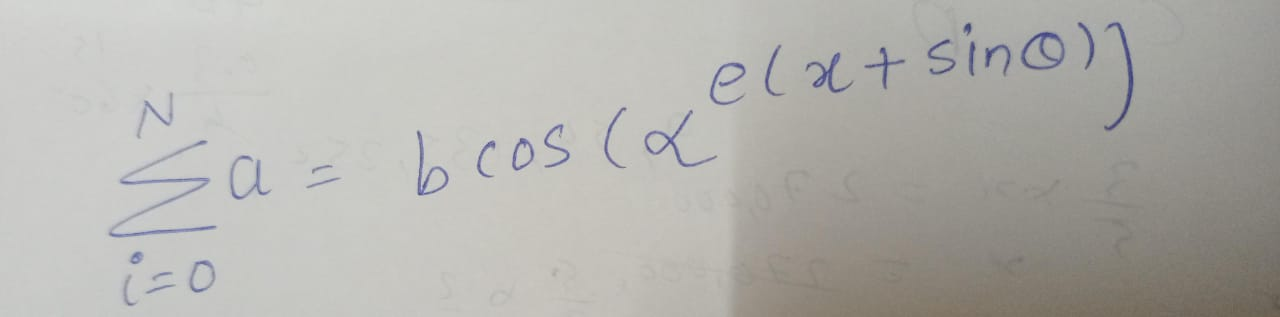

Prediction:
\frac { \frac { N } { \cos a = b \cos ( \alpha ^ { e } + \sin \theta ) )


<IPython.core.display.Math object>

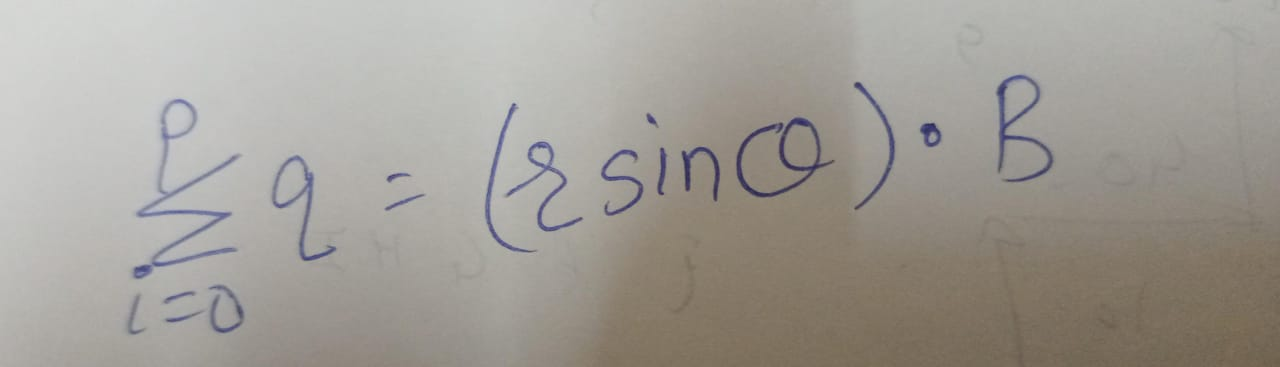

Prediction:
\frac { \sum _ { i = 0 } ^ { l } 2 = ( 2 \sin \theta ) \cdot B


<IPython.core.display.Math object>

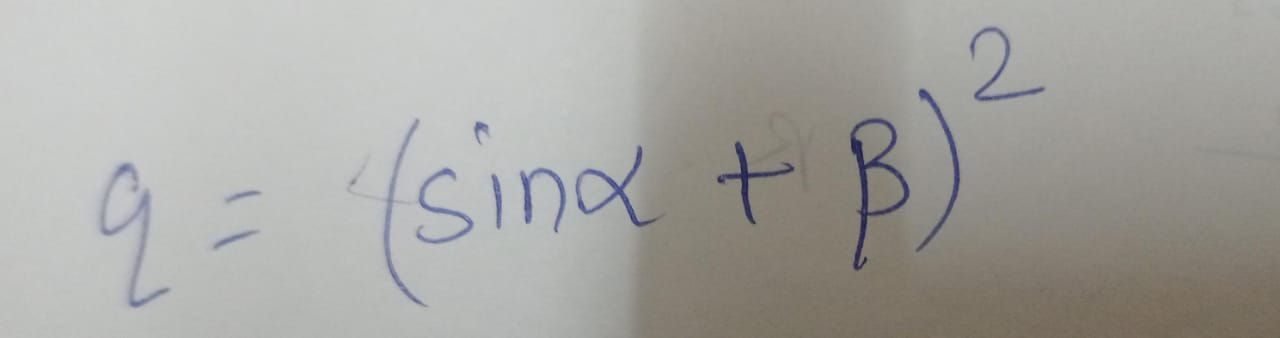

Prediction:
q = 1 ( \sin \alpha + \beta ) ^ { 2 }


<IPython.core.display.Math object>

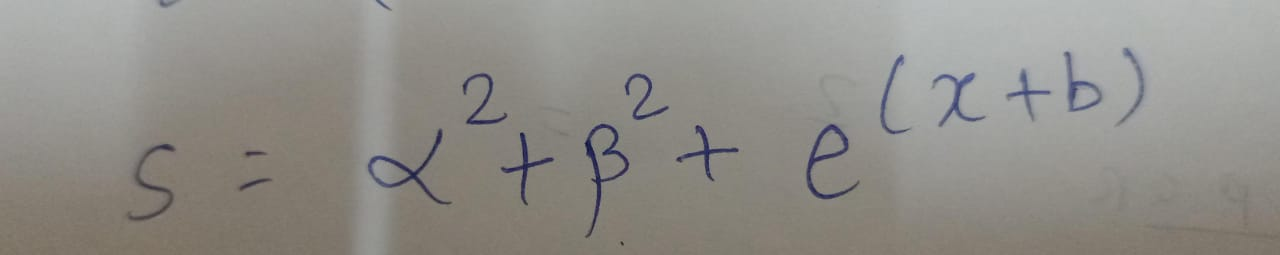

Prediction:
s = \alpha ^ { 2 } + \beta ^ { 2 } + e ^ { ( x + b ) }


<IPython.core.display.Math object>

In [19]:
# Save model and processor
from IPython.display import display, Math


# Function to test your own image
def test_custom_image(image_path):
    model.eval()
    # Load your image
    image = Image.open(image_path).convert('RGB')
    display(image)  # Display the image

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    out = model.generate(pixel_values, max_new_tokens=256)
    print("Prediction:")
    pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
    print(pred)
    display(Math(pred))

# Specify the path to your image
custom_image_path = "/kaggle/input/test-images-handwritten/WhatsApp Image 2024-11-18 at 20.57.58_3571a84e.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)

custom_image_path = "/kaggle/input/test-images-handwritten/WhatsApp Image 2024-11-18 at 20.58.30_1771234f.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)

custom_image_path = "/kaggle/input/test-images-handwritten/WhatsApp Image 2024-11-18 at 20.58.53_91708acc.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)

custom_image_path = "/kaggle/input/test-images-handwritten/WhatsApp Image 2024-11-18 at 20.59.13_254d685a.jpg"  # Replace with your image file path
test_custom_image(custom_image_path)
